In [1]:
" Preliminary setup "
from distutils.core import setup
import os
import numpy as np
import treecorr

import astropy.io.fits as pf
import fitsio
import sys
import os
import treecorr
import healpy as hp
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample

from scipy import spatial

import pickle

# setup notebook for inline figures
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
lensdata = pf.open('cosmoDC2_UDG_lens.fits')
sourcedata = pf.open('cosmoDC2_UDG_source.fits')
#print(sourcedata[1].header)

In [ ]:
plt.hist(sourcedata[1].data[, bins=30)

In [117]:
#cut the source
sc = (sourcedata[1].data['Z']>0.1)*(sourcedata[1].data['Z']<1)
ra_s = sourcedata[1].data['ra'][sc]
dec_s = sourcedata[1].data['DEC'][sc]
e1 = sourcedata[1].data['e1'][sc] + np.random.normal(0, 0.3, size=len(ra_s))
e2 = sourcedata[1].data['e2'][sc] + np.random.normal(0, 0.3, size=len(ra_s))
# cut the lens 7<log(SM)<8, 0.03<z<0.1 
#lc = (lensdata[1].data['Z']>0.03)*(lensdata[1].data['Z']<0.1)*(lensdata[1].data['SM']>10**7)*(lensdata[1].data['SM']<10**8)
#ra_l = lensdata[1].data['RA'][lc]
#dec_l = lensdata[1].data['DEC'][lc]
# cut the lens: 8<log(SM)<9, 0.03<z<0.1
lc = (lensdata[1].data['Z']>0.03)*(lensdata[1].data['Z']<0.1)*(lensdata[1].data['SM']>10**8)*(lensdata[1].data['SM']<10**9)
ra_l = lensdata[1].data['RA'][lc]
dec_l = lensdata[1].data['DEC'][lc]

In [118]:
#randomly draw 1750 lenses from the lensdata if it has more than 1750
import random
if len(ra_l) > 1750:
    index = list(range(len(ra_l)))
    randomlens = random.sample(index, 1750) 
    nra_l = []
    ndec_l = []
    for x in randomlens:
        nra_l.append(ra_l[x])
        ndec_l.append(dec_l[x])
    ra_l = np.array(nra_l)
    dec_l = np.array(ndec_l)

In [119]:
units='deg'
sens = np.ones(len(ra_s))
w = np.ones(len(ra_s))

In [120]:
ng = treecorr.NGCorrelation(nbins=20, min_sep=2.5, max_sep=250,sep_units='arcmin', bin_slop=0.05)
nk = treecorr.NKCorrelation(nbins=20, min_sep=2.5, max_sep=250,sep_units='arcmin', bin_slop=0.05)
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units=units, dec_units=units)
    
cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, g1=e1, g2=e2, w=w, ra_units=units, dec_units=units)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, k=sens, w=w, ra_units=units, dec_units=units)

ng.process_cross(cat_l, cat_s)
nk.process_cross(cat_l, cat_k)

In [121]:
#calcultating theta and gammat
theta = np.exp(ng.logr)
gammat = (ng.xi/nk.xi)

In [122]:
nbins = 20
n_jck=100
nside=2**10
err_bars = []

In [123]:
#defining jkfield
def DeclRatoIndex(ra, dec, nside):
    theta, phi = np.pi/2.-np.radians(dec), np.radians(ra)
    pix = hp.pixelfunc.ang2pix(nside, theta, phi)
    return pix

def IndexToDeclRa(index, nside):
    theta, phi = hp.pixelfunc.pix2ang(nside, index)
    dec = -np.degrees(theta-np.pi/2.); ra = np.degrees(phi)
    return dec, ra

def IndexToDeclRa1(index, nside):
    theta, phi = hp.pixelfunc.pix2ang(nside, index)
    return -np.degrees(theta-np.pi/2.), np.degrees(phi), theta,phi

def jaccknife_regions(ra, dec, number_of_regions, label_jck=None, centers_jck=None, v=False):
    new_cat = []
    for i in range(len(ra)):
        new_cat.append([ra[i],dec[i]])
    new_cat = np.array(new_cat)
    A = new_cat[np.random.randint(new_cat.shape[0], size=20000),:]
    centers_jck = kmeans_radec.kmeans_sample(A, number_of_regions, maxiter=100, tol=1e-05, verbose=0)
    centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
    _ , hpix = centers_tree.query(new_cat)
    return centers_tree, hpix, centers_jck.centers[:,[0,1]]

def negotiate(jkfield, nside, mask, theta, phi, nmaxborderiter):
    
    sortjk = np.sort(jkfield)
    jkcounts = np.bincount(jkfield)  
    npix = hp.nside2npix(nside)  
    pixel2indx = np.zeros(npix,dtype=int)        # ipix to index in the mask-only-array
    pixel2indx = -1*pixel2indx                   # -1 : pixel has no indx assigned
    pixel2indx[mask] = np.array(range(len(pixel2indx[mask])))

    for mute in range(nmaxborderiter):  # iterate over border negotiation
        ichange = 0; irare = 0

        for indx in sortjk:
            jk1 = jkfield[indx]
            ipixarr = hp.get_all_neighbours(nside, theta[indx], phi[indx]) # 8 neighbours, will use only 4
            
            for j in range(8):
                ipix2 = ipixarr[j] 

                if (ipix2 < 0) : 
                    irare = irare+1
                    continue 

                indx2 = pixel2indx[ipix2]
                jk2 = jkfield[indx2] 

                if ( jkcounts[jk1] < jkcounts[jk2]):
                    ichange = ichange+1
                    jkfield[indx2] = jk1
                    jkcounts[jk2] = jkcounts[jk2]-1
                    jkcounts[jk1] = jkcounts[jk1]+1
    return jkfield
        
mask_sims = DeclRatoIndex(ra_l, dec_l, nside)
area = np.array(range(hp.nside2npix(nside)))[mask_sims]
dec, ra = IndexToDeclRa(area, nside)
centers_tree, hpix, centers = jaccknife_regions(ra, dec, n_jck)
new_cat = []
for i in range(len(ra)):
    new_cat.append([ra[i],dec[i]])
new_cat = np.array(new_cat)
A = new_cat[np.random.randint(new_cat.shape[0], size=50000),:]
centers_jck = kmeans_radec.kmeans_sample(A, n_jck, maxiter=100, tol=1e-05, verbose=0)
dec, ra, theta1, phi = IndexToDeclRa1(area, nside)
jkfield = centers_jck.find_nearest(new_cat)
jkfield1 = negotiate(jkfield, nside, mask_sims, theta1, phi, 7)

In [124]:
#calculating covariance matrix
Gammat_jck = []; cov = []

for i in range(nbins):
    cov.append(np.zeros(nbins))
cov = np.array(cov)
jck_pathches = np.array(range(n_jck))


for k in range(n_jck): # Jackknife regions
    mask_l = jkfield1 != k
    ira_l = ra_l[mask_l]; idec_l = dec_l[mask_l]
    ng = treecorr.NGCorrelation(nbins=20, min_sep=2.5, max_sep=250,sep_units='arcmin', bin_slop=0.05)
    nk = treecorr.NKCorrelation(nbins=20, min_sep=2.5, max_sep=250,sep_units='arcmin', bin_slop=0.05)
    
    cat_l = treecorr.Catalog(ra=ira_l, dec=idec_l, ra_units=units, dec_units=units)
    
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, g1=e1, g2=e2, w=w, ra_units=units, dec_units=units)
    cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, k=sens, w=w, ra_units=units, dec_units=units)

    ng.process_cross(cat_l, cat_s)
    nk.process_cross(cat_l, cat_k)
    Gammat_jck.append(list(ng.xi/nk.xi))
Gammat_jck = np.array(Gammat_jck)
for m in range(nbins):
    gti = Gammat_jck[:,m]
    for n in range(nbins):
        gtj = Gammat_jck[:,n]
        cov[m][n] = (n_jck - 1) * np.mean( ( gti - np.mean(gti)) * ( gtj - np.mean(gtj) ))

print("Done calculating covariance matrix")

Done calculating covariance matrix


In [125]:
#save the results
np.savetxt('thetasecondcutsn.txt',theta)
np.savetxt('gammatsecondcutsn.txt', gammat)
np.savetxt('jkfield1secondcutsn.txt', jkfield1)
np.savetxt('covsecondcutsn.txt', cov)

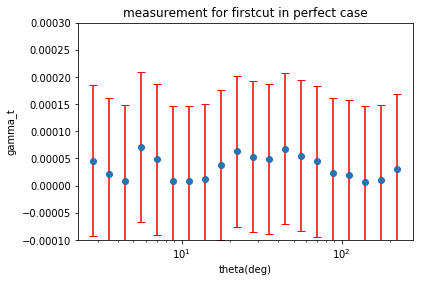

In [6]:
#ploting the results
theta = np.loadtxt('thetafirstcut.txt')
gammat = np.loadtxt('gammatfirstcut.txt')
cov = np.loadtxt('covfirstcut.txt')
err_bars = np.sqrt(np.sum(np.diagonal(cov)))
fig = plt.figure()
plt.scatter(theta, np.abs(gammat), marker='o')
plt.errorbar(theta, np.abs(gammat),  yerr=err_bars, fmt='o', markersize=5, ecolor='r', capsize=4)
plt.xscale('log')
plt.xlabel('theta(deg)')
#plt.yscale('log')
plt.ylabel('gamma_t')
plt.title('measurement for firstcut in perfect case')
plt.ylim(-1.e-4, 3.e-4)
#plt.ylim(1.e-8,1.e-2)
plt.show()

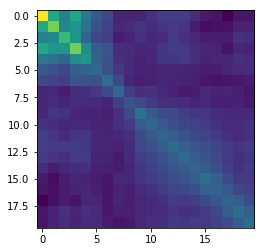

In [13]:
plt.imshow(cov)

In [14]:
#S/N = [D C^{-1} D^{T}]^0.5
snratio = np.sqrt(np.matmul(np.matmul(gammat,np.linalg.inv(cov)),np.matrix.transpose(gammat)))
print(snratio)

4.608433540201187


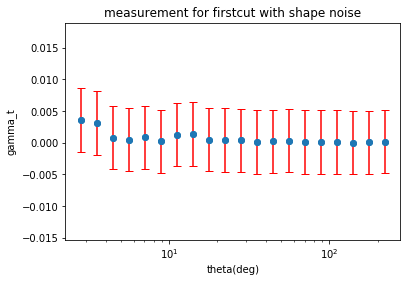

In [8]:
#ploting the results
theta = np.loadtxt('thetafirstcutsn.txt')
gammat = np.loadtxt('gammatfirstcutsn.txt')
cov = np.loadtxt('covfirstcutsn.txt')
err_bars = np.sqrt(np.sum(np.diagonal(cov)))
fig = plt.figure()
plt.scatter(theta, np.abs(gammat), marker='o')
plt.errorbar(theta, np.abs(gammat),  yerr=err_bars, fmt='o', ecolor='r', capsize=4)
plt.xscale('log')
plt.xlabel('theta(deg)')
#plt.yscale('log')
plt.ylabel('gamma_t')
plt.title('measurement for firstcut with shape noise')
#plt.ylim(-1.e-4, 3.e-4)
#plt.ylim(1.e-8,1.e-2)
plt.show()

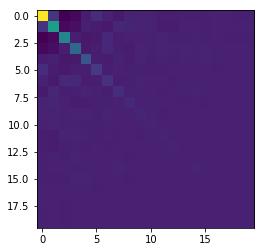

In [39]:
plt.imshow(cov)

In [40]:
#S/N = [D C^{-1} D^{T}]^0.5
snratio = np.sqrt(np.matmul(np.matmul(gammat,np.linalg.inv(cov)),np.matrix.transpose(gammat)))
print(snratio)

5.756585602056609


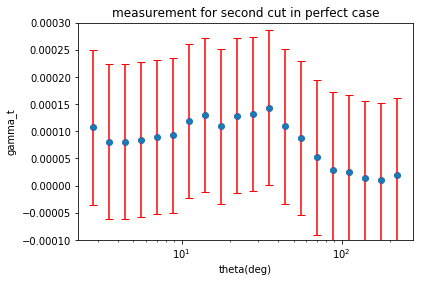

In [7]:
#ploting the results
theta = np.loadtxt('thetasecondcut.txt')
gammat = np.loadtxt('gammatsecondcut.txt')
cov = np.loadtxt('covsecondcut.txt')
err_bars = np.sqrt(np.sum(np.diagonal(cov)))
fig = plt.figure()
plt.scatter(theta, np.abs(gammat), marker='o')
plt.errorbar(theta, np.abs(gammat),  yerr=err_bars, fmt='o', markersize=5, ecolor='r', capsize=4)
plt.xscale('log')
plt.xlabel('theta(deg)')
#plt.yscale('log')
plt.ylabel('gamma_t')
plt.title('measurement for second cut in perfect case')
plt.ylim(-1.e-4, 3.e-4)
#plt.ylim(1.e-8,1.e-2)
plt.show()

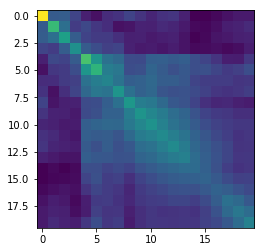

In [113]:
plt.imshow(cov)

In [114]:
#S/N = [D C^{-1} D^{T}]^0.5
snratio = np.sqrt(np.matmul(np.matmul(gammat,np.linalg.inv(cov)),np.matrix.transpose(gammat)))
print(snratio)

6.885478228538489


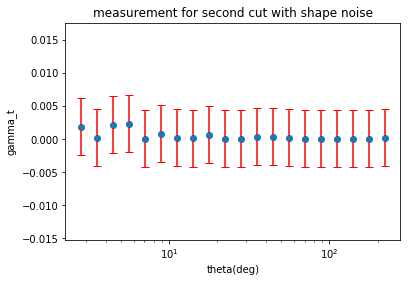

In [9]:
#ploting the results
theta = np.loadtxt('thetasecondcutsn.txt')
gammat = np.loadtxt('gammatsecondcutsn.txt')
cov = np.loadtxt('covsecondcutsn.txt')
err_bars = np.sqrt(np.sum(np.diagonal(cov)))
fig = plt.figure()
plt.scatter(theta, np.abs(gammat), marker='o')
plt.errorbar(theta, np.abs(gammat),  yerr=err_bars, fmt='o', markersize=5, ecolor='r', capsize=4)
plt.xscale('log')
plt.xlabel('theta(deg)')
#plt.yscale('log')
plt.ylabel('gamma_t')
plt.title('measurement for second cut with shape noise')
#plt.ylim(-1.e-4, 3.e-4)
#plt.ylim(1.e-8,1.e-2)
plt.show()

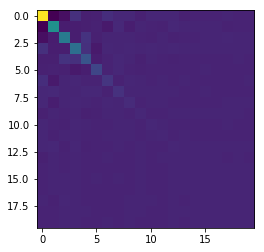

In [127]:
plt.imshow(cov)

In [128]:
#S/N = [D C^{-1} D^{T}]^0.5
snratio = np.sqrt(np.matmul(np.matmul(gammat,np.linalg.inv(cov)),np.matrix.transpose(gammat)))
print(snratio)

4.883930052059953


In [5]:
sourcedata[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20 / length of dimension 1                          
NAXIS2  =              1050195 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'Z       '        